/var/folders/c4/98dp1lqj4kq9n2s3k05mvq7m0000gn/T/ipykernel_5184/3001830004.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2022-01-01", end="2024-12-01")['Close']
[*********************100%***********************]  30 of 30 completed


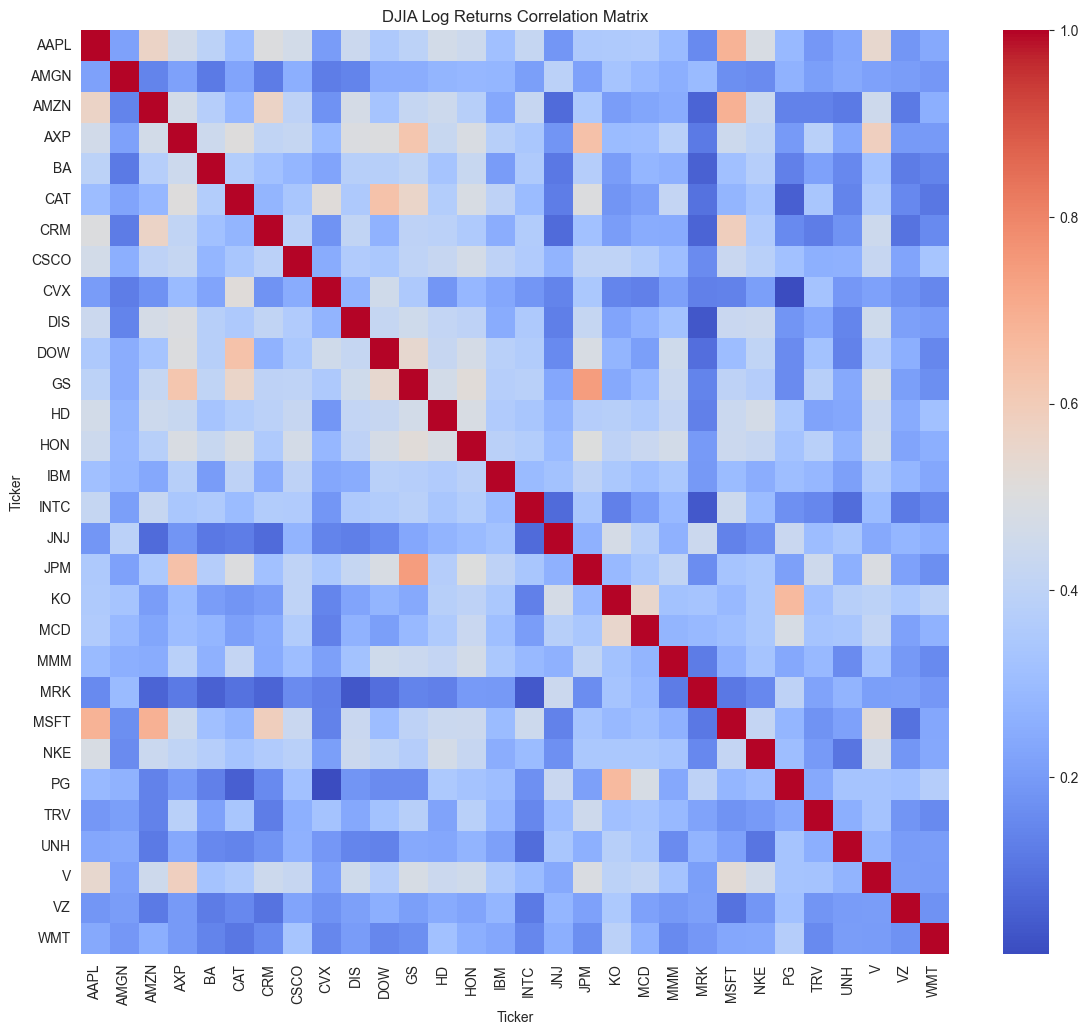

In [38]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import math

# Defining the 30 DJIA Tickers
tickers = [
    'MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS',
    'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK',
    'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WMT', 'AMZN'
]

# 1. Retrieving Data (Min 2 years as per instructions)
data = yf.download(tickers, start="2022-01-01", end="2024-12-01")['Close']

# 2. Computing Log Returns using ln(price_t) - ln(price_{t-1})
log_returns = np.log(data / data.shift(1)).dropna()

# 3. Correlation Matrix
correlation_matrix = log_returns.corr(method='pearson')

# Visualization
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('DJIA Log Returns Correlation Matrix')
plt.show()

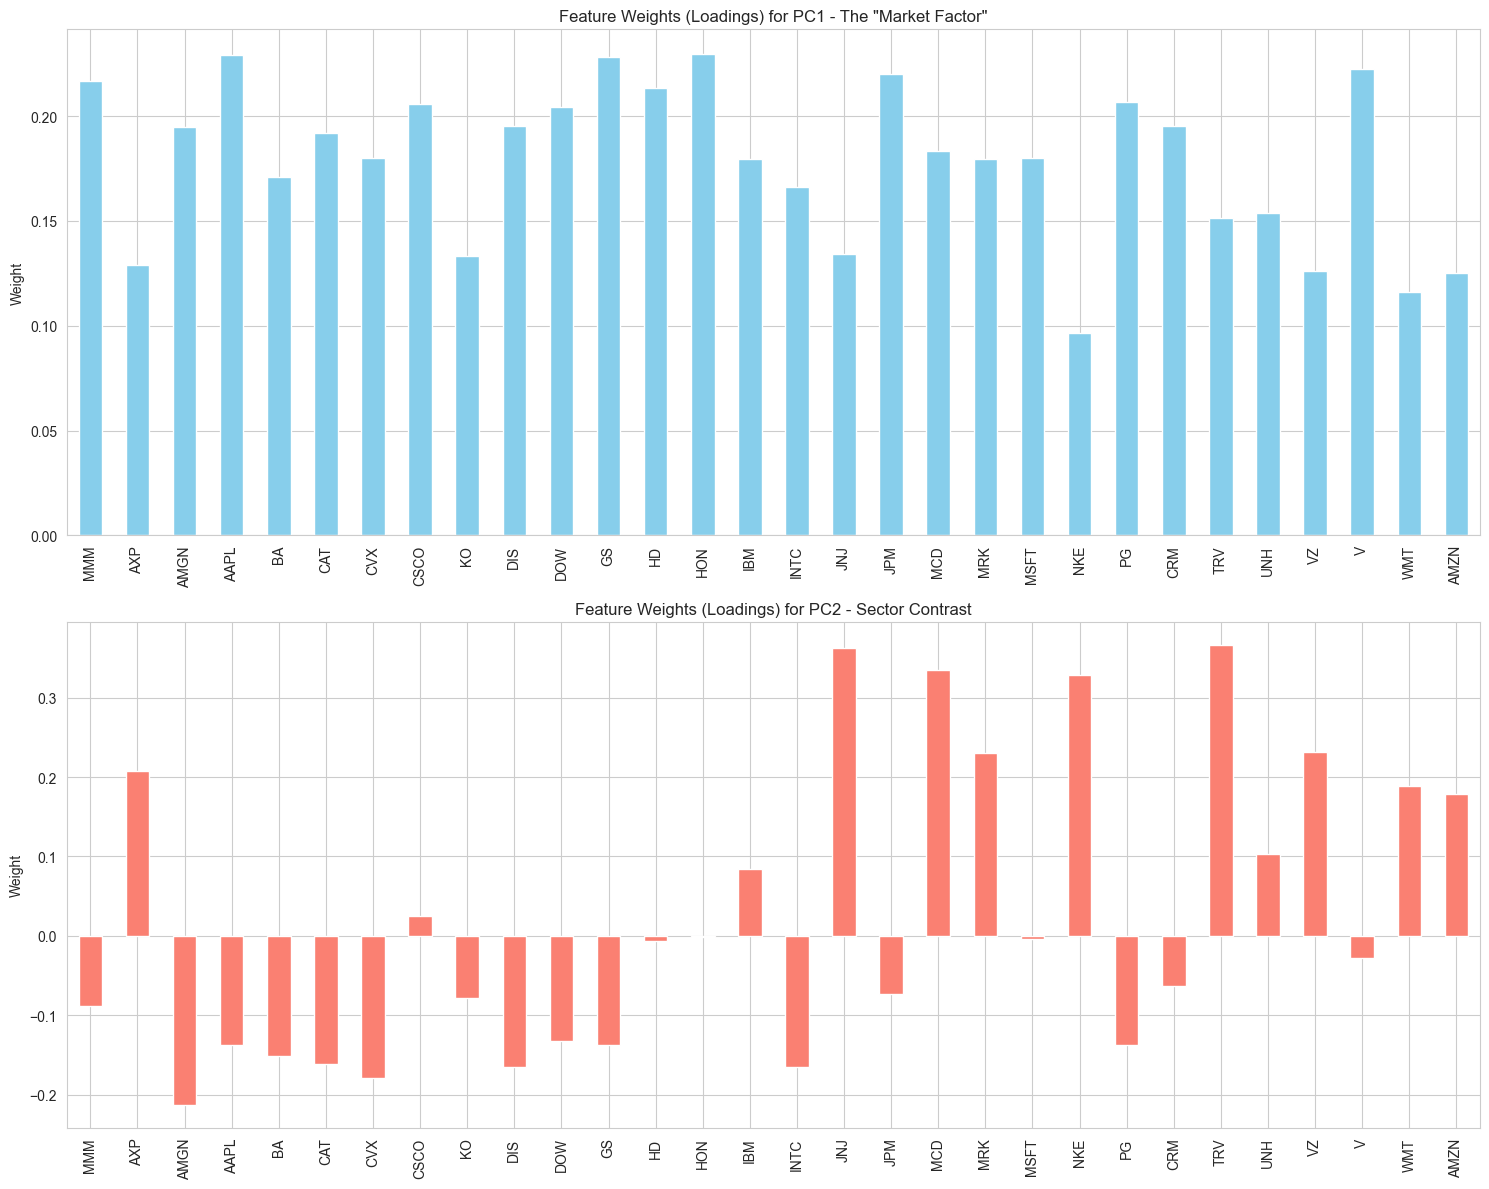

In [39]:
# Standardizing the data (Crucial for PCA)
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(log_returns)

# Performing PCA
pca = PCA(n_components=30)
pca.fit(scaled_returns)

# Extract Loadings (Eigenvectors)
loadings = pd.DataFrame(pca.components_.T, index=tickers, columns=[f'PC{i+1}' for i in range(30)])

# Plotting PC1 and PC2
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# PC1 Bar Chart
loadings['PC1'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Feature Weights (Loadings) for PC1 - The "Market Factor"')
axes[0].set_ylabel('Weight')

# PC2 Bar Chart
loadings['PC2'].plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Feature Weights (Loadings) for PC2 - Sector Contrast')
axes[1].set_ylabel('Weight')

plt.tight_layout()
plt.show()

Number of components required to explain 95% variance: 25


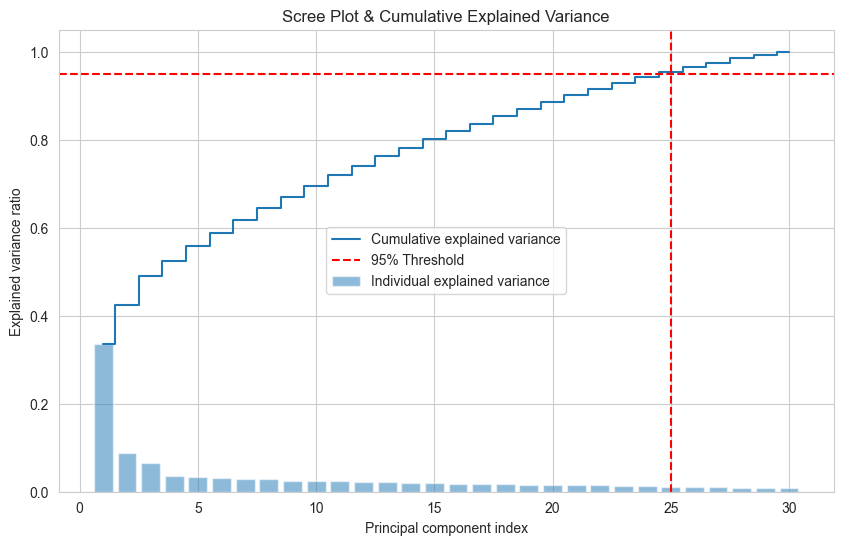

In [40]:
# Calculating Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Find k for 95% variance
k_95 = np.argmax(cumulative_variance >= 0.95) + 1  # +1 because index starts at 0

print(f"Number of components required to explain 95% variance: {k_95}")

# Visualization using a Scree Plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, 31), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, 31), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.axvline(x=k_95, color='r', linestyle='--')
plt.legend(loc='best')
plt.title('Scree Plot & Cumulative Explained Variance')
plt.show()

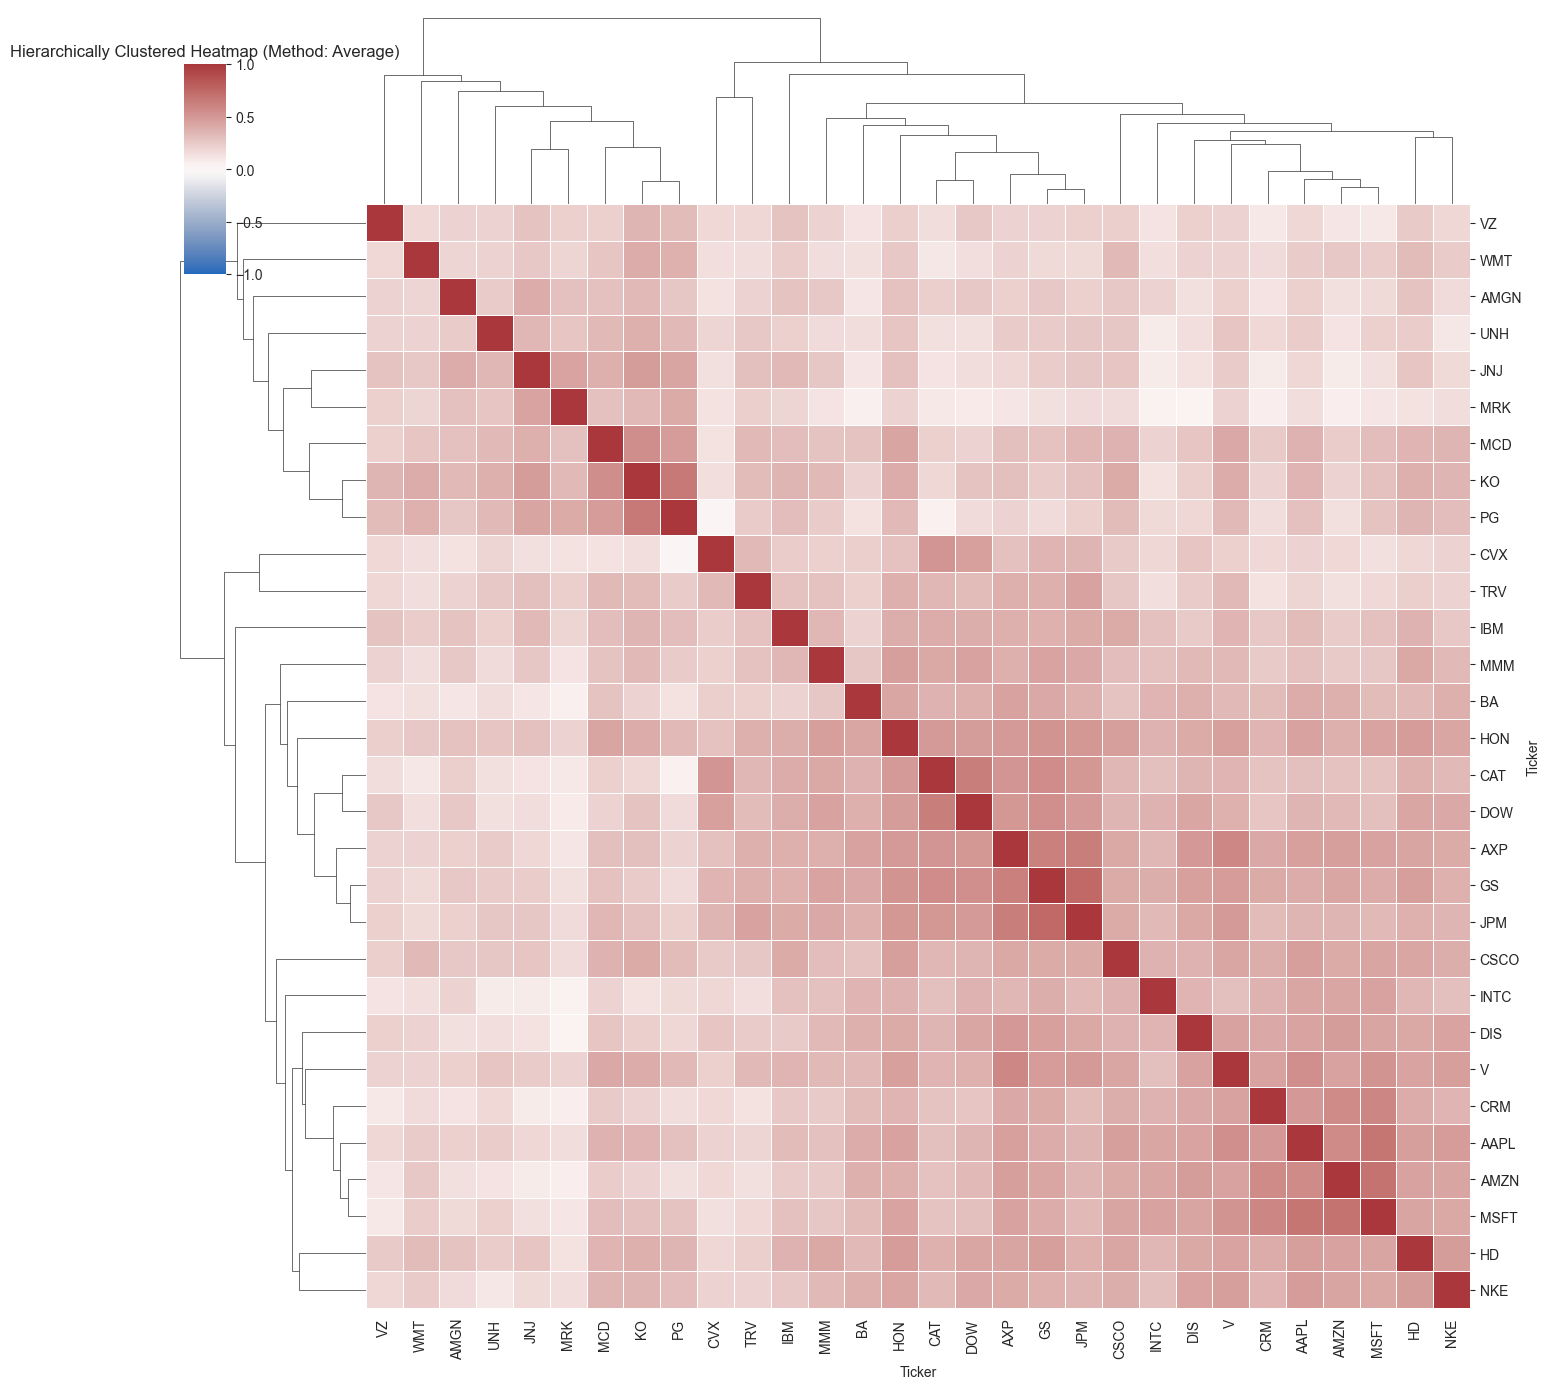

Reordered Tickers (Look for blocks in this order):
['WMT', 'AMZN', 'AXP', 'VZ', 'JNJ', 'NKE', 'MRK', 'MCD', 'TRV', 'KO', 'UNH', 'IBM', 'MSFT', 'BA', 'HON', 'CAT', 'DOW', 'AAPL', 'GS', 'JPM', 'CSCO', 'INTC', 'DIS', 'V', 'CVX', 'MMM', 'AMGN', 'PG', 'HD', 'CRM']


In [25]:
clustermap = sns.clustermap(
    correlation_matrix,
    method='average',
    metric='correlation',
    cmap='vlag',
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    figsize=(14, 14),
    dendrogram_ratio=(0.15, 0.15),
    cbar_pos=(0.02, 0.8, 0.03, 0.15)
)

plt.title('Hierarchically Clustered Heatmap (Method: Average)')
plt.show()

# Extracting the reordered list of tickers
reordered_tickers = [tickers[i] for i in clustermap.dendrogram_row.reordered_ind]
print("Reordered Tickers (Look for blocks in this order):")
print(reordered_tickers)

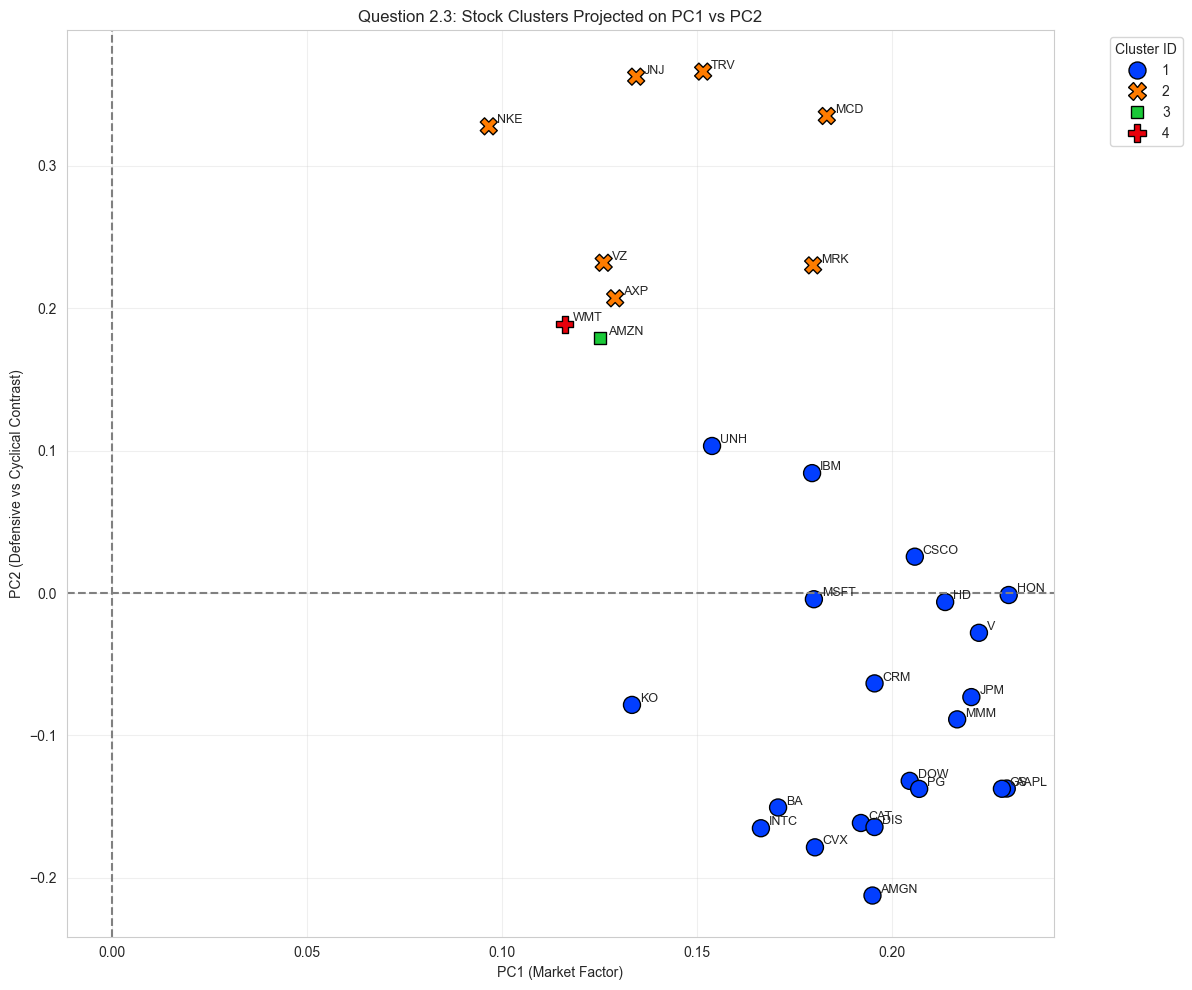


Cluster 1 Members: ['MMM', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JPM', 'MSFT', 'PG', 'CRM', 'UNH', 'V']

Cluster 2 Members: ['AXP', 'JNJ', 'MCD', 'MRK', 'NKE', 'TRV', 'VZ']

Cluster 3 Members: ['AMZN']

Cluster 4 Members: ['WMT']


In [26]:
distance_matrix = np.sqrt(2 * (1 - correlation_matrix))
# Converting to condensed form for scipy
condensed_dist = squareform(distance_matrix)

# 2. Performing Hierarchical Clustering using 'average' linkage as established
Z = sch.linkage(condensed_dist, method='average')

# 3. Form 4 Clusters
cluster_labels = fcluster(Z, t=4, criterion='maxclust')

# Creating a DataFrame to store results
cluster_df = pd.DataFrame({
    'Ticker': tickers,
    'Cluster': cluster_labels,
    'PC1': loadings['PC1'],
    'PC2': loadings['PC2']
})

# 4. Creating the Scatter Plot
plt.figure(figsize=(12, 10))

# Creating a custom color palette for 4 clusters
palette = sns.color_palette("bright", 4)
sns.scatterplot(
    data=cluster_df,
    x='PC1', y='PC2',
    hue='Cluster',
    style='Cluster',
    palette=palette,
    s=150, # Marker size
    edgecolor='black'
)

# Labelig points with Ticker names
for i in range(cluster_df.shape[0]):
    plt.text(
        cluster_df.PC1.iloc[i]+0.002,
        cluster_df.PC2.iloc[i]+0.002,
        cluster_df.Ticker.iloc[i],
        fontsize=9
    )

plt.title('Question 2.3: Stock Clusters Projected on PC1 vs PC2')
plt.xlabel('PC1 (Market Factor)')
plt.ylabel('PC2 (Defensive vs Cyclical Contrast)')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Listing Members of Each Cluster
for i in range(1, 5):
    members = cluster_df[cluster_df['Cluster'] == i]['Ticker'].tolist()
    print(f"\nCluster {i} Members: {members}")

/var/folders/c4/98dp1lqj4kq9n2s3k05mvq7m0000gn/T/ipykernel_5184/3958043532.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('PG', start='2000-01-01', end='2024-12-01', interval='1mo')['Close']
[*********************100%***********************]  1 of 1 completed


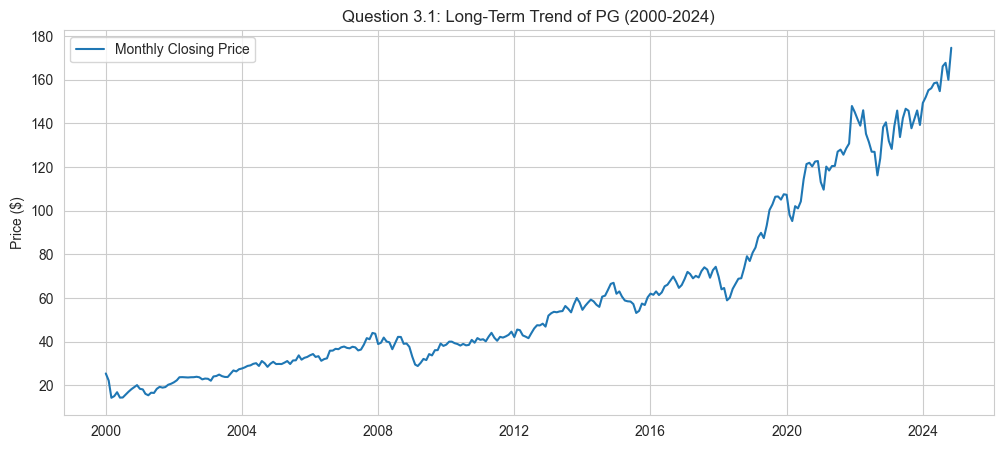

--- Test 1: Original Series ---
Results of Dickey-Fuller Test:
Test Statistic                   2.635949
p-value                          0.999081
#Lags Used                       6.000000
Number of Observations Used    292.000000
Critical Value (1%)             -3.452945
Critical Value (5%)             -2.871490
Critical Value (10%)            -2.572071
dtype: float64

Conclusion: Series is NON-STATIONARY (Fail to reject Null Hypothesis)


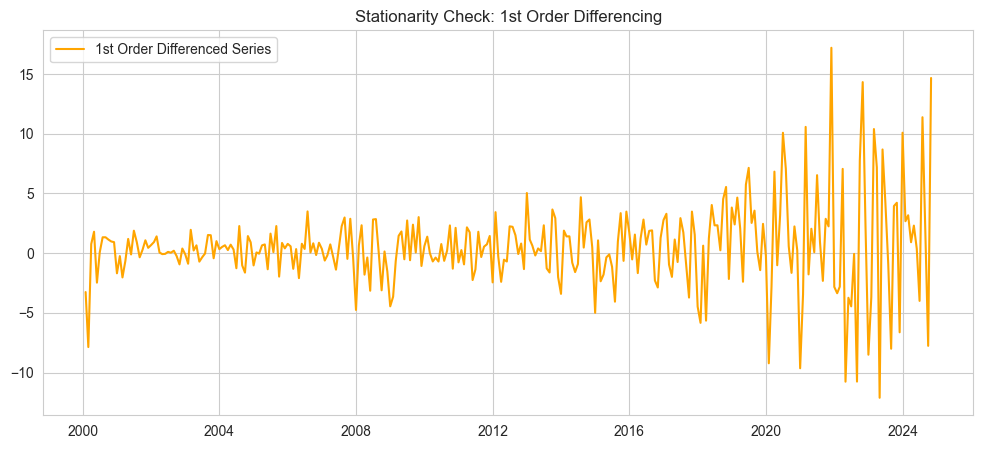


--- Test 2: Differenced Series ---
Results of Dickey-Fuller Test:
Test Statistic                -8.278178e+00
p-value                        4.595672e-13
#Lags Used                     5.000000e+00
Number of Observations Used    2.920000e+02
Critical Value (1%)           -3.452945e+00
Critical Value (5%)           -2.871490e+00
Critical Value (10%)          -2.572071e+00
dtype: float64

Conclusion: Series is STATIONARY (Reject Null Hypothesis)


In [29]:
# Fetching monthly data for a long period 20 years
df = yf.download('PG', start='2000-01-01', end='2024-12-01', interval='1mo')['Close']
df = df.dropna()

# Visual Inspection of Long-Term Trend
plt.figure(figsize=(12, 5))
plt.plot(df, label='Monthly Closing Price')
plt.title('Question 3.1: Long-Term Trend of PG (2000-2024)')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

#  Augmented Dickey-Fuller (ADF) Test Function
def run_adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput['p-value'] < 0.05:
        print("\nConclusion: Series is STATIONARY (Reject Null Hypothesis)")
    else:
        print("\nConclusion: Series is NON-STATIONARY (Fail to reject Null Hypothesis)")

# Run Test on Original Data
print("--- Test 1: Original Series ---")
run_adf_test(df)

# 4. Non-Stationary test using  the first difference: Price_t - Price_{t-1}
df_diff = df.diff().dropna()

# Ploting Differenced Data
plt.figure(figsize=(12, 5))
plt.plot(df_diff, color='orange', label='1st Order Differenced Series')
plt.title('Stationarity Check: 1st Order Differencing')
plt.legend()
plt.show()

# Running Test on Differenced Data
print("\n--- Test 2: Differenced Series ---")
run_adf_test(df_diff)

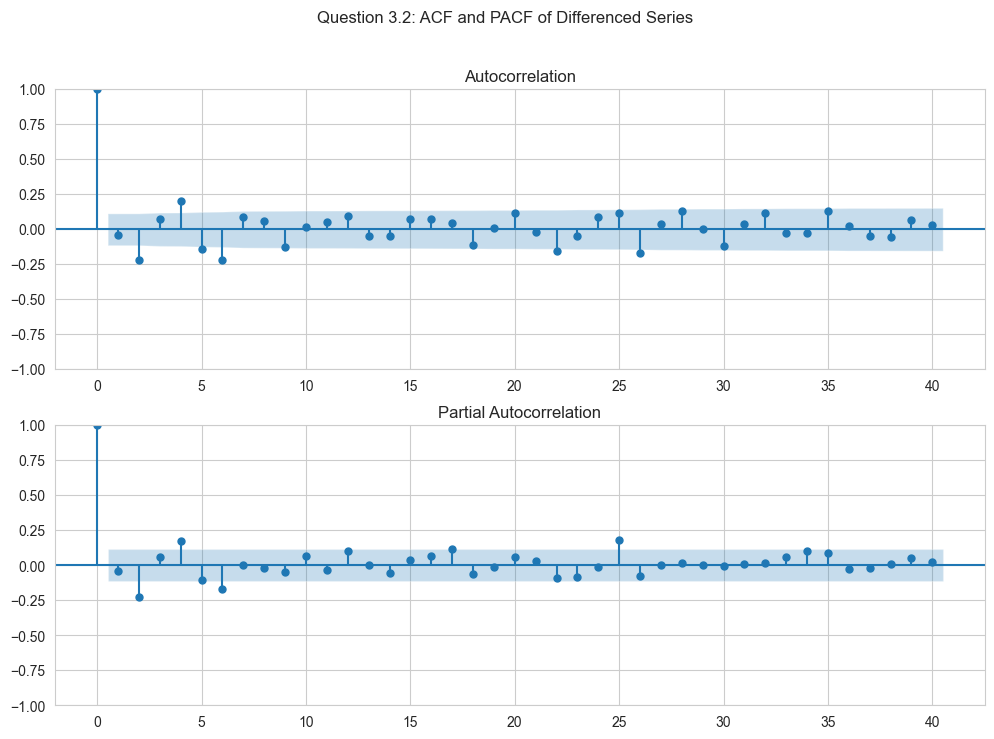

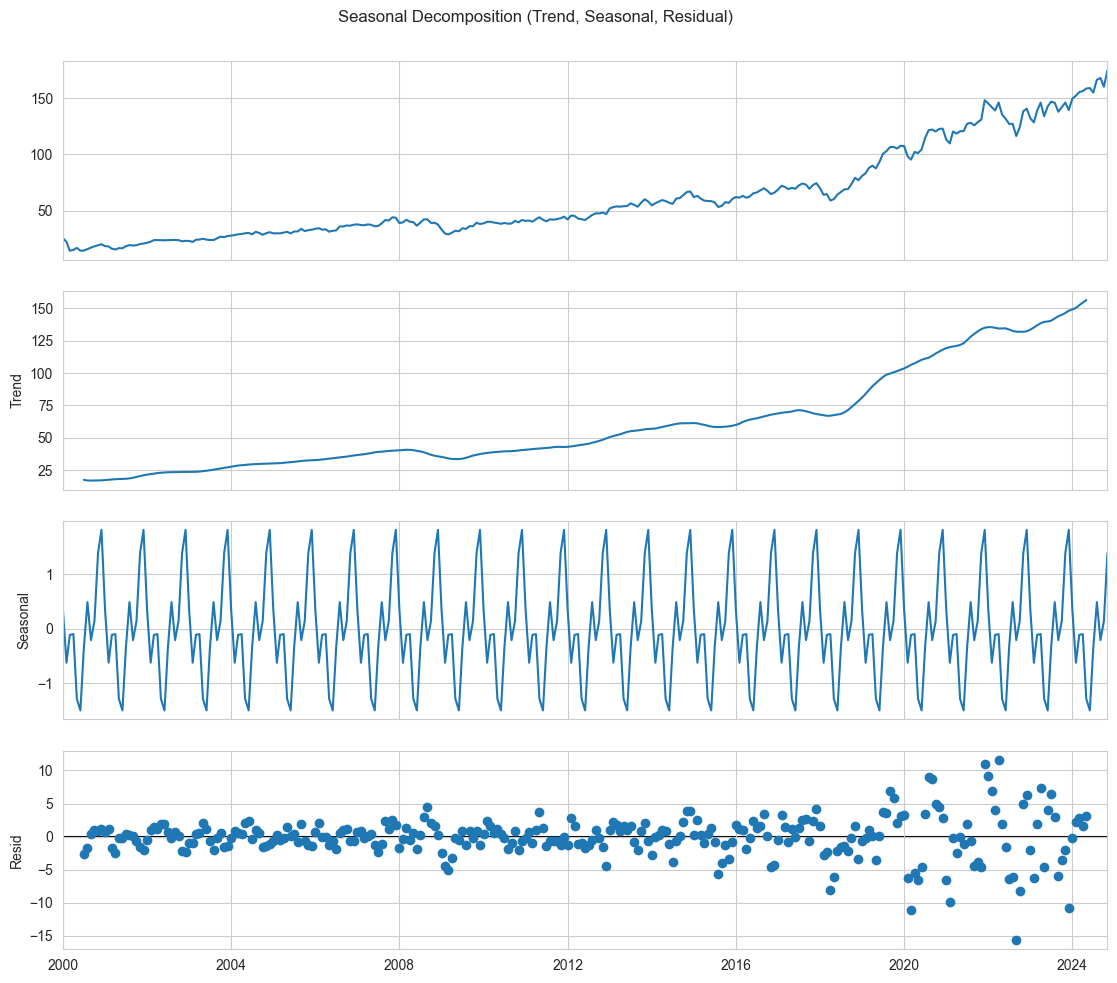

In [32]:
# 1. ACF and PACF Plots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_diff, lags=40, ax=ax[0])
plot_pacf(df_diff, lags=40, ax=ax[1])
plt.suptitle('Question 3.2: ACF and PACF of Differenced Series')
plt.show()

# 2. Seasonal Decomposition (STL)
decomposition = seasonal_decompose(df, model='additive', period=12)

fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.suptitle('Seasonal Decomposition (Trend, Seasonal, Residual)', y=1.02)
plt.show()

Training Samples: 263, Testing Samples: 36
Running Simple MA...
Simple MA -> MAE: 9.9333, RMSE: 11.6100
Training ARIMA...


/Users/mac/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/mac/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA (1,1,1) -> MAE: 6.2936, RMSE: 7.7834
Training LSTM...


/Users/mac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
LSTM -> MAE: 6.1381, RMSE: 7.4869


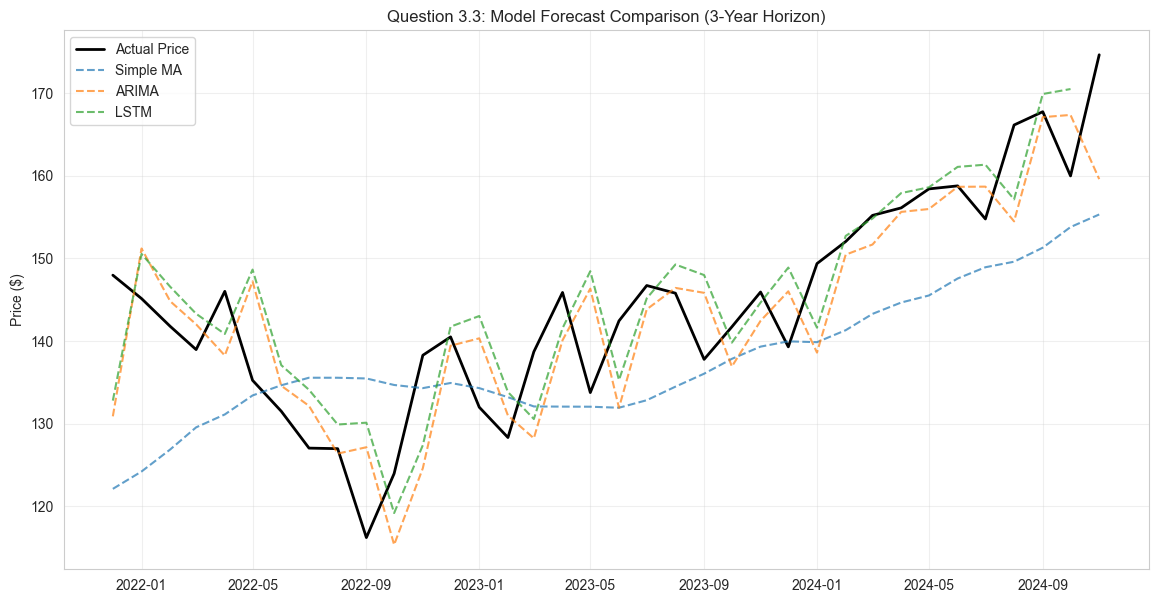

In [34]:
# Ensure df is a Series of floats, not a DataFrame
if isinstance(df, pd.DataFrame):
    # removes extra dimensions)
    df_series = df.squeeze()
    # If still DataFrame (rare), force select first column
    if isinstance(df_series, pd.DataFrame):
        df_series = df_series.iloc[:, 0]
else:
    df_series = df

# Split into Train and Test (Last 3 Years for Test)
test_size = 36
train = df_series[:-test_size]
test = df_series[-test_size:]

print(f"Training Samples: {len(train)}, Testing Samples: {len(test)}")

# Metric Calculation Helper
def evaluate_forecast(actual, pred, model_name):
    # Ensure inputs are same length/type
    min_len = min(len(actual), len(pred))
    mae = mean_absolute_error(actual[:min_len], pred[:min_len])
    rmse = math.sqrt(mean_squared_error(actual[:min_len], pred[:min_len]))
    print(f"{model_name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return mae, rmse

history = train.values.flatten().tolist()
ma_preds = []
window_size = 12

print("Running Simple MA...")
for t in range(len(test)):
    # Average of last 'window_size' observations
    yhat = np.mean(history[-window_size:])
    ma_preds.append(yhat)
    # Append the actual test value (scalar) to history
    history.append(float(test.iloc[t]))

ma_mae, ma_rmse = evaluate_forecast(test, ma_preds, "Simple MA")


# MODEL 2: ARIMA (Auto-Regressive Integrated Moving Average)
arima_preds = []
history = train.values.flatten().tolist()

# Walk-forward validation
print("Training ARIMA...")
for t in range(len(test)):
    # Order (1,1,1) is a standard baseline for stocks
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arima_preds.append(yhat)
    history.append(float(test.iloc[t]))

arima_mae, arima_rmse = evaluate_forecast(test, arima_preds, "ARIMA (1,1,1)")


# MODEL 3: LSTM (Long Short-Term Memory)

# Preprocessing: Neural Networks require scaling (0 to 1)
scaler = MinMaxScaler(feature_range=(0, 1))
# reshape(-1, 1) ensures we have a 2D array [rows, 1 column]
scaled_data = scaler.fit_transform(df_series.values.reshape(-1, 1))

# Helper to create sequences (X=Past 12 months, Y=Next month)
def create_dataset(dataset, look_back=12):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 12
train_size = len(train)
# We need some overlap from train to predict the first test point
train_scaled = scaled_data[0:train_size, :]
test_scaled = scaled_data[train_size-look_back:, :]

X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM Architecture
print("Training LSTM...")
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=False, input_shape=(look_back, 1)))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, batch_size=1, epochs=20, verbose=0) # Increased epochs slightly

# Prediction
lstm_preds_scaled = model_lstm.predict(X_test)
lstm_preds = scaler.inverse_transform(lstm_preds_scaled)

# Adjust dimensions for evaluation
lstm_mae, lstm_rmse = evaluate_forecast(test[:len(lstm_preds)], lstm_preds, "LSTM")


# VISUALIZATION
plt.figure(figsize=(14, 7))
plt.plot(test.index, test.values, label='Actual Price', color='black', linewidth=2)
plt.plot(test.index, ma_preds, label='Simple MA', linestyle='--', alpha=0.7)
plt.plot(test.index, arima_preds, label='ARIMA', linestyle='--', alpha=0.7)
# Align LSTM x-axis
plt.plot(test.index[:len(lstm_preds)], lstm_preds, label='LSTM', linestyle='--', alpha=0.7)
plt.title('Question 3.3: Model Forecast Comparison (3-Year Horizon)')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Generating Future Forecast...


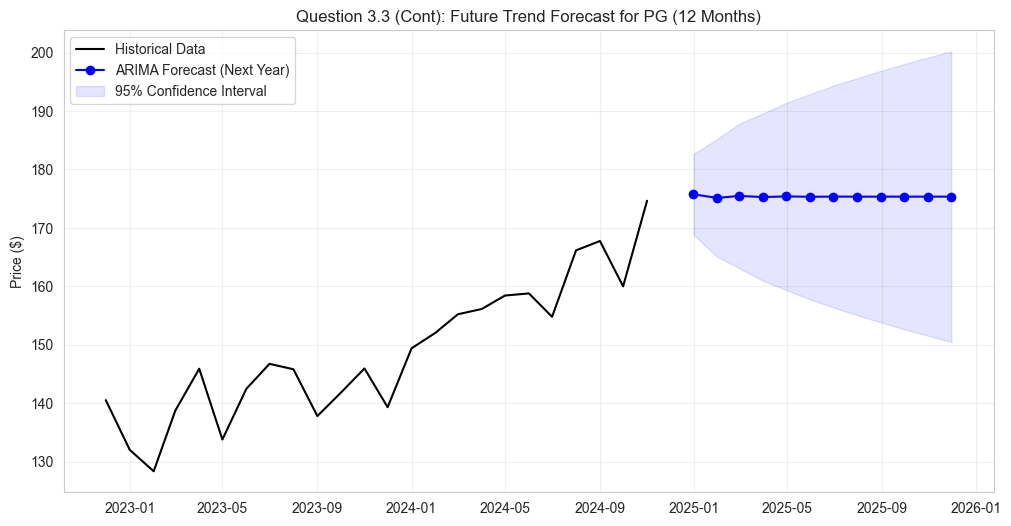


Forecasted Prices for Next 12 Months:
2024-12-31: $175.75
2025-01-31: $175.13
2025-02-28: $175.48
2025-03-31: $175.28
2025-04-30: $175.39
2025-05-31: $175.33
2025-06-30: $175.36
2025-07-31: $175.34
2025-08-31: $175.35
2025-09-30: $175.35
2025-10-31: $175.35
2025-11-30: $175.35


In [37]:
# Based on the evaluation, we select ARIMA(1,1,1) as the best model.
# 1. Fit model on all available data
full_history = df_series.values.tolist()
final_model = ARIMA(full_history, order=(1,1,1))
final_model_fit = final_model.fit()

# 2. Forecasting next 12 months
future_steps = 12
forecast_result = final_model_fit.get_forecast(steps=future_steps)
future_forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05) # 95% Confidence Interval

# 3. Creating Date Index for Future
last_date = df_series.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps+1, freq='ME')[1:]

# 4. Visualization
plt.figure(figsize=(12, 6))

# Ploting recent actual history (last 2 years for context)
plt.plot(df_series.index[-24:], df_series.values[-24:], label='Historical Data', color='black')

# Ploting Future Forecast
plt.plot(future_dates, future_forecast, label='ARIMA Forecast (Next Year)', color='blue', marker='o')

# Plot Confidence Intervals (Shaded Region)
plt.fill_between(future_dates,
                 conf_int[:, 0],
                 conf_int[:, 1],
                 color='blue', alpha=0.1, label='95% Confidence Interval')

plt.title(f'Question 3.3 (Cont): Future Trend Forecast for PG (12 Months)')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nForecasted Prices for Next 12 Months:")
for date, price in zip(future_dates, future_forecast):
    print(f"{date.date()}: ${price:.2f}")